# Notebook 07: Well-being Across the Global Income Distribution

Previous notebooks focused on rich-country comparisons — the US, UK, and
Nordic/European peers. But how do well-being outcomes vary when we zoom
out to the full global income spectrum?

This notebook compares ~24 countries spanning high-income, upper-middle,
lower-middle, and low-income tiers across four dimensions:

1. **Health**: life expectancy, infant/child mortality, hospital beds, health spending
2. **Material living standards**: poverty, electricity access, GDP per capita
3. **Education**: literacy, secondary and tertiary enrollment
4. **Subjective well-being**: happiness (Cantril Ladder)

### Key questions
- Where does someone at the US 10th percentile sit relative to the Brazilian 50th?
- Is the relationship between income and health linear, or do returns diminish?
- Does the US get good value for its income level on health and education?
- At what income level does happiness stop rising?

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from scipy import stats

from data.config import (
    FOCUS_COUNTRIES, WELLBEING_COUNTRIES, COUNTRY_NAMES, COUNTRY_COLORS,
    ISO2_TO_ISO3,
)
from data.plotting import (
    set_style, country_color, country_name, save_figure, annotate_countries,
)
from data import health_social, wid

set_style()

# Income tier classification for coloring
INCOME_TIERS = {
    'High income': ['US', 'GB', 'FR', 'DE', 'SE', 'DK', 'NO', 'JP', 'AU', 'CL'],
    'Upper-middle': ['CN', 'BR', 'MX', 'ZA', 'TR', 'RU'],
    'Lower-middle': ['IN', 'ID', 'PH', 'EG', 'NG'],
    'Low income': ['ET', 'BD'],
}
TIER_COLORS = {
    'High income': '#4878a8',
    'Upper-middle': '#4a9a73',
    'Lower-middle': '#c06820',
    'Low income': '#b5403a',
}
COUNTRY_TIER = {}
for tier, codes in INCOME_TIERS.items():
    for c in codes:
        COUNTRY_TIER[c] = tier

def tier_color(code):
    return TIER_COLORS.get(COUNTRY_TIER.get(code, ''), '#999999')


In [2]:
# Load the wellbeing cross-country dataset
wb_data = health_social.get_wellbeing_data(year=2019)

print(f"Countries loaded: {len(wb_data)}")
print(f"Columns: {list(wb_data.columns)}")
display(wb_data.head(10))

Countries loaded: 23
Columns: ['country_code', 'gini_disp', 'life_expectancy', 'infant_mortality', 'under5_mortality', 'hospital_beds', 'health_expenditure_pct_gdp', 'gdp_per_capita_ppp', 'poverty_215', 'electricity_access', 'literacy_rate', 'secondary_enrollment', 'tertiary_enrollment', 'country_name']


,country_code,gini_disp,life_expectancy,infant_mortality,under5_mortality,hospital_beds,health_expenditure_pct_gdp,gdp_per_capita_ppp,poverty_215,electricity_access,literacy_rate,secondary_enrollment,tertiary_enrollment,country_name
0,AU,32.6,82.900000,3.2,3.8,3.82,10.254214,52885.831382,1.0,100.0,NaN,144.056564,109.759560,Australia
1,BD,33.9,72.625000,25.4,32.4,0.89,2.127126,6047.124015,19.5,92.2,74.680000,65.118541,22.709464,Bangladesh
2,BR,47.2,75.809000,13.0,15.0,2.29,9.614491,16069.838015,7.0,99.8,93.901925,103.953278,52.624062,Brazil
3,CL,46.4,80.324000,6.0,7.0,2.02,9.309685,25611.757827,1.7,100.0,96.400002,104.405769,92.065971,Chile
4,CN,41.0,77.940000,6.0,8.0,4.82,5.265169,17600.890757,0.0,100.0,96.739998,NaN,56.605092,China
5,DE,30.0,81.292683,3.1,3.7,7.87,11.428054,59270.727650,0.2,100.0,NaN,101.152557,72.705078,Germany
6,DK,28.0,81.451220,3.3,3.8,2.59,10.184688,60594.966400,0.3,100.0,NaN,129.311127,81.694588,Denmark
7,EG,38.9,71.213000,18.4,20.1,1.19,4.599467,13363.732696,2.0,100.0,71.169998,77.909398,33.622826,Egypt
8,ET,33.2,65.741000,41.0,54.1,0.33,3.242871,2242.444883,38.6,48.0,55.049999,33.911422,5.919251,Ethiopia
9,FR,29.8,82.826829,3.3,4.2,5.96,11.170583,51130.472314,0.1,100.0,NaN,104.076897,67.733131,France


***
## 1. Income Across the Global Distribution: The Elephant Chart

How does average income at each decile compare across countries?
This directly answers questions like: *Is someone at the US 10th percentile
richer than someone at Brazil's 50th?*

We use PPP-adjusted post-tax average income from the World Inequality Database.

In [3]:
# Decile percentile codes for WID
decile_pctiles = [f"p{i*10}p{(i+1)*10}" for i in range(10)]

# WID income data is in local currency units. We need PPP exchange rates
# matched to the SAME YEAR as the income data to convert correctly.
# (PPP rates shift substantially with inflation, especially in developing countries.)

elephant_countries = [c for c in WELLBEING_COUNTRIES]

elephant_frames = []
for cc in elephant_countries:
    try:
        df = wid.get_average_income(
            countries=[cc], income_concept='posttax',
            percentiles=decile_pctiles,
            start_year=2015, end_year=2022,
        )
        if not df.empty:
            # Take most recent year available
            latest = df.groupby('percentile')['year'].max().min()
            df = df[df['year'] == latest]
            df = df[['country', 'percentile', 'value']].copy()
            # Get PPP rate matched to the income data year
            ppp = wid.get_ppp_exchange_rates([cc], year=latest)
            if cc in ppp and ppp[cc] > 0:
                df['value'] = df['value'] / ppp[cc]
                elephant_frames.append(df)
    except Exception as e:
        print(f"  Skipping {cc}: {e}")

if elephant_frames:
    elephant_df = pd.concat(elephant_frames, ignore_index=True)
    # Extract decile number for ordering
    elephant_df['decile'] = elephant_df['percentile'].str.extract(r'p(\d+)p').astype(int) // 10 + 1
    print(f"Elephant chart data: {elephant_df['country'].nunique()} countries, "
          f"{len(elephant_df)} rows")
    # Spot-check
    for cc in ['US', 'IN', 'ET', 'BR', 'NG']:
        med = elephant_df[(elephant_df['country'] == cc) & (elephant_df['decile'] == 5)]
        if not med.empty:
            print(f"  {cc} median (D5) PPP: ${med['value'].values[0]:,.0f}")
else:
    elephant_df = pd.DataFrame()
    print("No WID data available for elephant chart.")

# Also build a per-country year-matched PPP rate dict for the heatmap
ppp_rates_matched = {}
for cc in elephant_countries:
    try:
        df = wid.get_average_income(
            countries=[cc], income_concept='posttax',
            percentiles=['p40p50'],
            start_year=2015, end_year=2022,
        )
        if not df.empty:
            latest = df['year'].max()
            ppp = wid.get_ppp_exchange_rates([cc], year=latest)
            if cc in ppp:
                ppp_rates_matched[cc] = ppp[cc]
    except Exception:
        pass

Elephant chart data: 23 countries, 230 rows
  US median (D5) PPP: $59,023
  IN median (D5) PPP: $5,426
  ET median (D5) PPP: $6,359
  BR median (D5) PPP: $10,245
  NG median (D5) PPP: $8,310


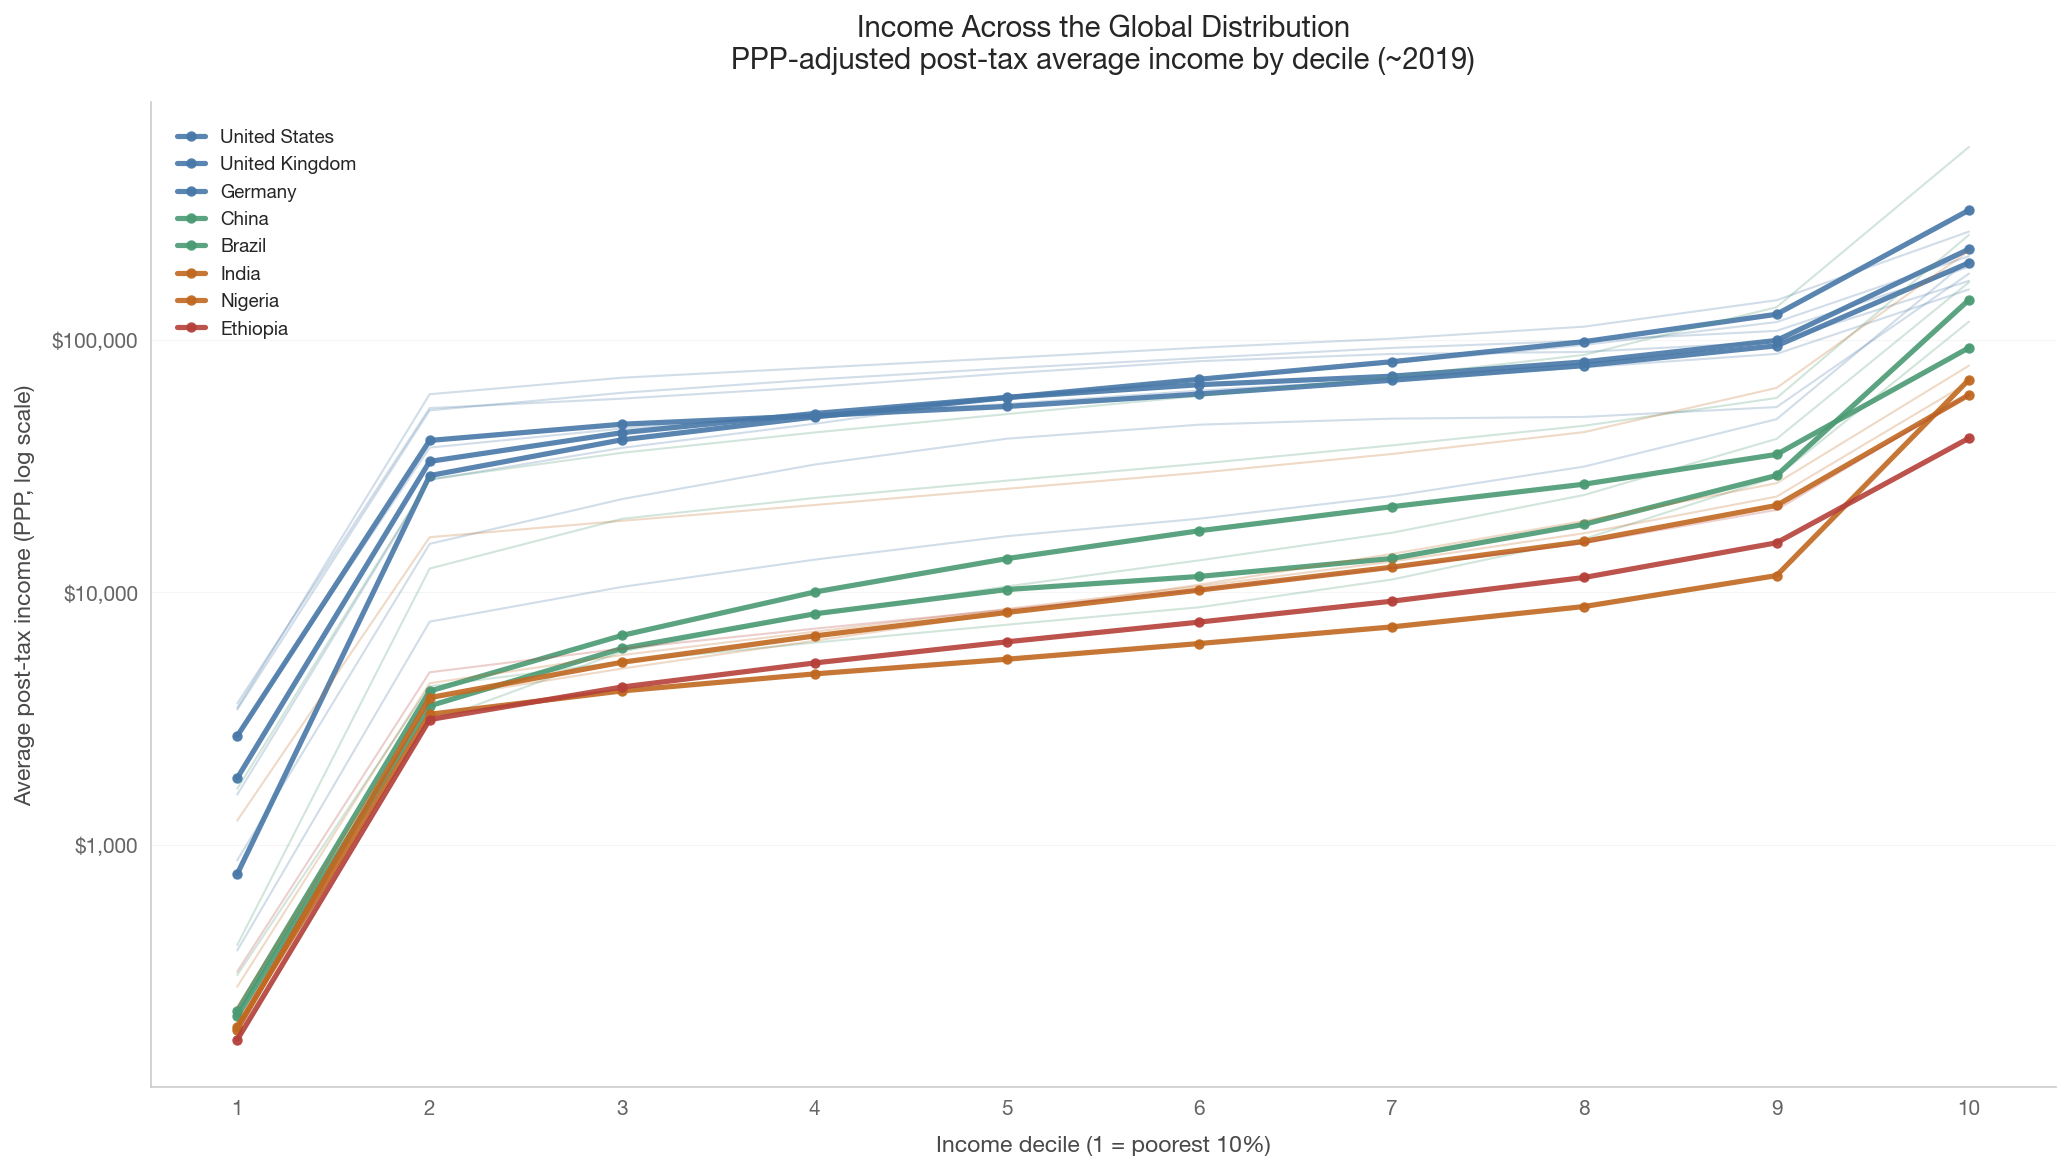

In [4]:
if not elephant_df.empty:
    fig, ax = plt.subplots(figsize=(14, 8))

    # Sort countries by median income (decile 5) for visual ordering
    median_income = (elephant_df[elephant_df['decile'] == 5]
                     .set_index('country')['value'])

    # Highlight a subset of countries for readability
    highlight = ['US', 'DE', 'GB', 'BR', 'CN', 'IN', 'NG', 'ET']
    highlight = [c for c in highlight if c in elephant_df['country'].unique()]

    for cc in elephant_df['country'].unique():
        cdf = elephant_df[elephant_df['country'] == cc].sort_values('decile')
        if cc in highlight:
            ax.plot(cdf['decile'], cdf['value'],
                    color=tier_color(cc), linewidth=2.5, alpha=0.9,
                    label=country_name(cc), marker='o', markersize=4)
        else:
            ax.plot(cdf['decile'], cdf['value'],
                    color=tier_color(cc), linewidth=1, alpha=0.25)

    ax.set_yscale('log')
    ax.set_xlabel('Income decile (1 = poorest 10%)')
    ax.set_ylabel('Average post-tax income (PPP, log scale)')
    ax.set_title('Income Across the Global Distribution\n'
                 'PPP-adjusted post-tax average income by decile (~2019)',
                 fontsize=14)
    ax.set_xticks(range(1, 11))
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(
        lambda x, _: f'${x:,.0f}' if x >= 1 else f'${x:.2f}'))
    ax.legend(loc='upper left', fontsize=9)
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    save_figure(fig, '07_elephant_chart')
    plt.show()
else:
    print('Elephant chart data not available.')

***
## 2. The Preston Curve: Life Expectancy and Income

The Preston Curve (1975) is one of the most robust relationships in
development economics: life expectancy rises steeply with national income
at low levels, then flattens. Enormous health gains come from moving
from $2k to $10k GDP/capita; the gains from $40k to $80k are marginal.

The US is a well-known underperformer — lower life expectancy than
countries with half its income.

/var/folders/fh/gvmnlwv90s90_gd0vgv823980000gn/T/ipykernel_82555/3810709504.py:43: UserWarning: Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from font(s) Helvetica Neue.
  plt.tight_layout()
/Users/clayborneo/Desktop/claude_code/research/income_inequality/notebooks/../data/plotting.py:186: UserWarning: Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from font(s) Helvetica Neue.
  fig.savefig(path, bbox_inches="tight", facecolor="white",


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from font(s) Helvetica Neue.
  fig.canvas.print_figure(bytes_io, **kw)


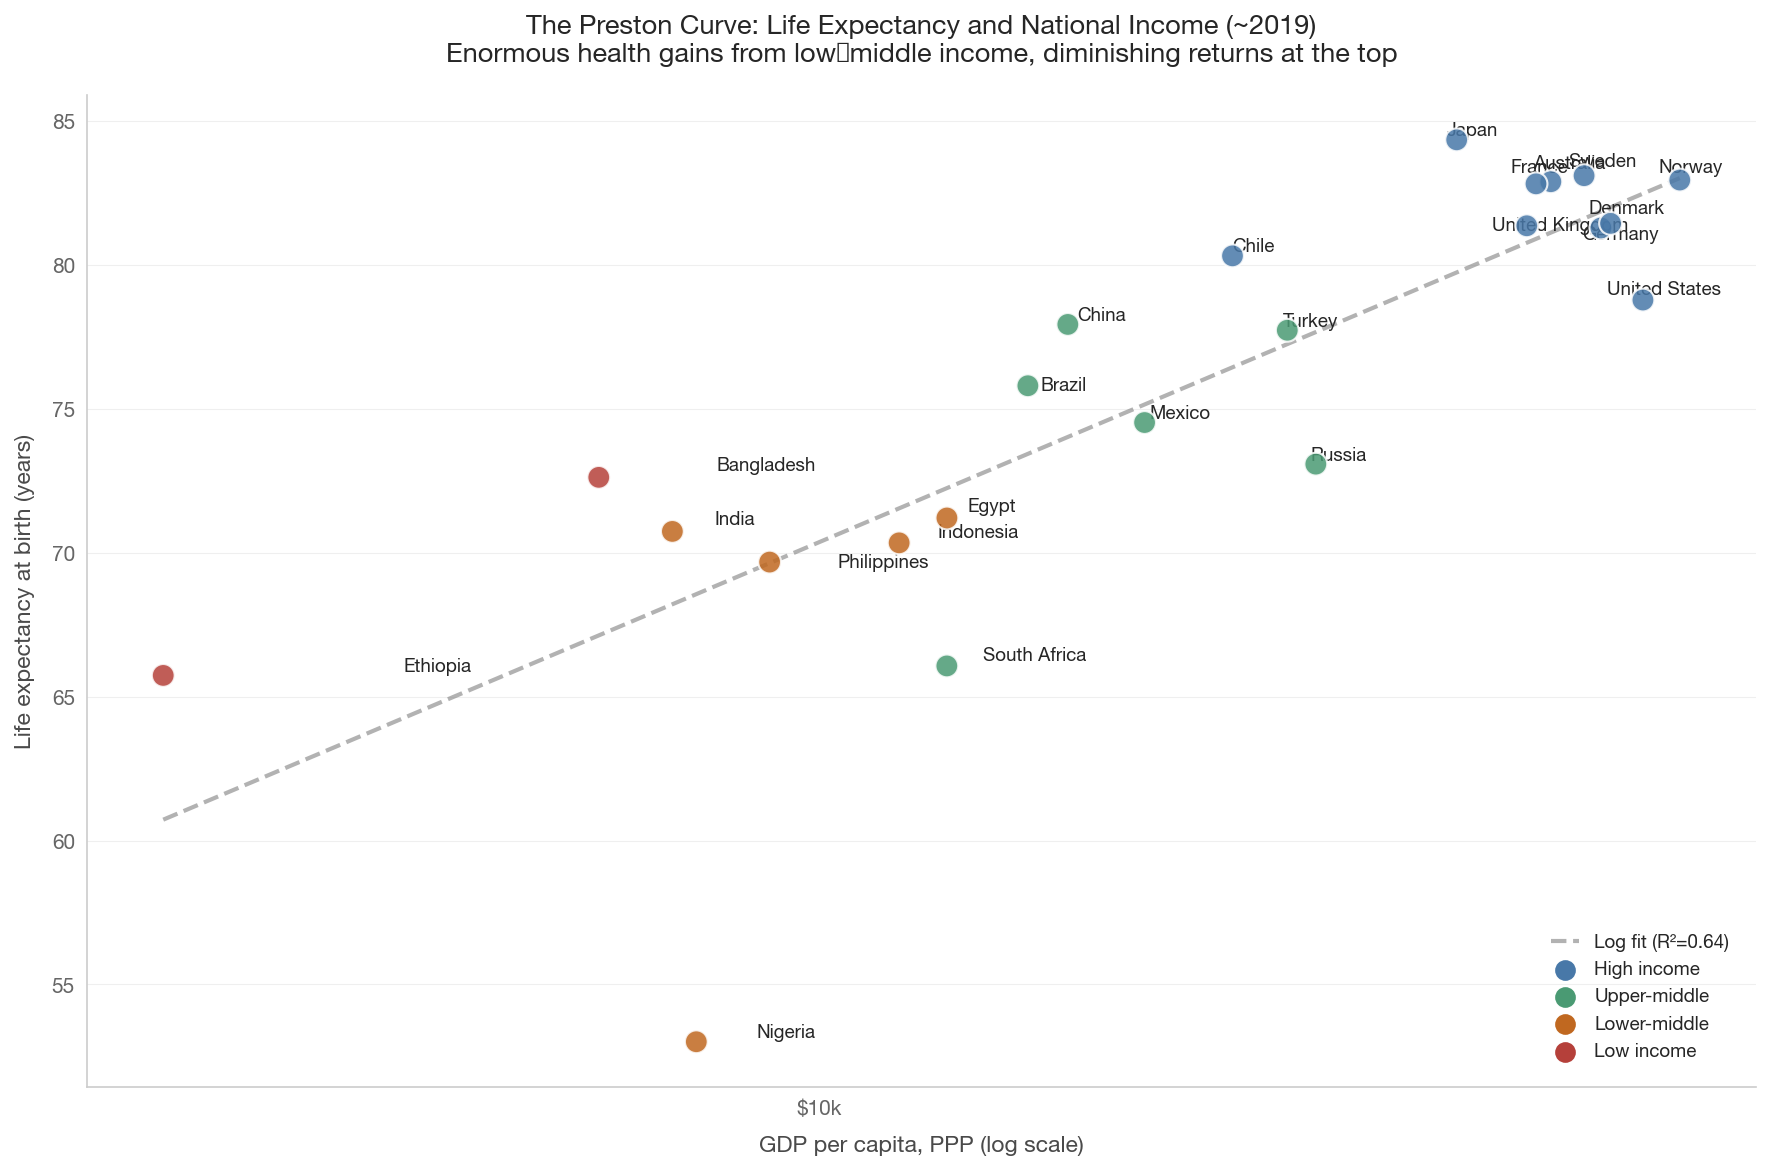

In [5]:
if (not wb_data.empty
        and 'gdp_per_capita_ppp' in wb_data.columns
        and 'life_expectancy' in wb_data.columns):

    df = wb_data.dropna(subset=['gdp_per_capita_ppp', 'life_expectancy'])

    fig, ax = plt.subplots(figsize=(12, 8))

    colors = [tier_color(c) for c in df['country_code']]
    ax.scatter(df['gdp_per_capita_ppp'], df['life_expectancy'],
               c=colors, s=120, zorder=5, edgecolors='white', linewidth=1,
               alpha=0.85)

    # Log fit line
    x = np.log(df['gdp_per_capita_ppp'].values)
    y = df['life_expectancy'].values
    mask = np.isfinite(x) & np.isfinite(y)
    if mask.sum() > 3:
        slope, intercept, r, p, se = stats.linregress(x[mask], y[mask])
        x_fit = np.linspace(x[mask].min(), x[mask].max(), 200)
        ax.plot(np.exp(x_fit), intercept + slope * x_fit,
                color='gray', linestyle='--', linewidth=2, alpha=0.6,
                label=f'Log fit (R\u00b2={r**2:.2f})')

    annotate_countries(ax, df['gdp_per_capita_ppp'].values,
                       df['life_expectancy'].values,
                       df['country_code'].values)

    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(mtick.FuncFormatter(
        lambda x, _: f'${x/1000:.0f}k'))
    ax.set_xlabel('GDP per capita, PPP (log scale)')
    ax.set_ylabel('Life expectancy at birth (years)')
    ax.set_title('The Preston Curve: Life Expectancy and National Income (~2019)\n'
                 'Enormous health gains from low\u2192middle income, diminishing returns at the top',
                 fontsize=13)

    # Legend for income tiers
    for tier, color in TIER_COLORS.items():
        ax.scatter([], [], c=color, s=80, label=tier)
    ax.legend(loc='lower right', fontsize=9)

    plt.tight_layout()
    save_figure(fig, '07_preston_curve')
    plt.show()
else:
    print('GDP or life expectancy data not available.')

***
## 3. Health Outcomes Across Income Tiers

Small multiples showing health indicators against GDP per capita.
The pattern is consistent: the biggest health gains come from the
transition out of poverty, not from getting richer at the top.

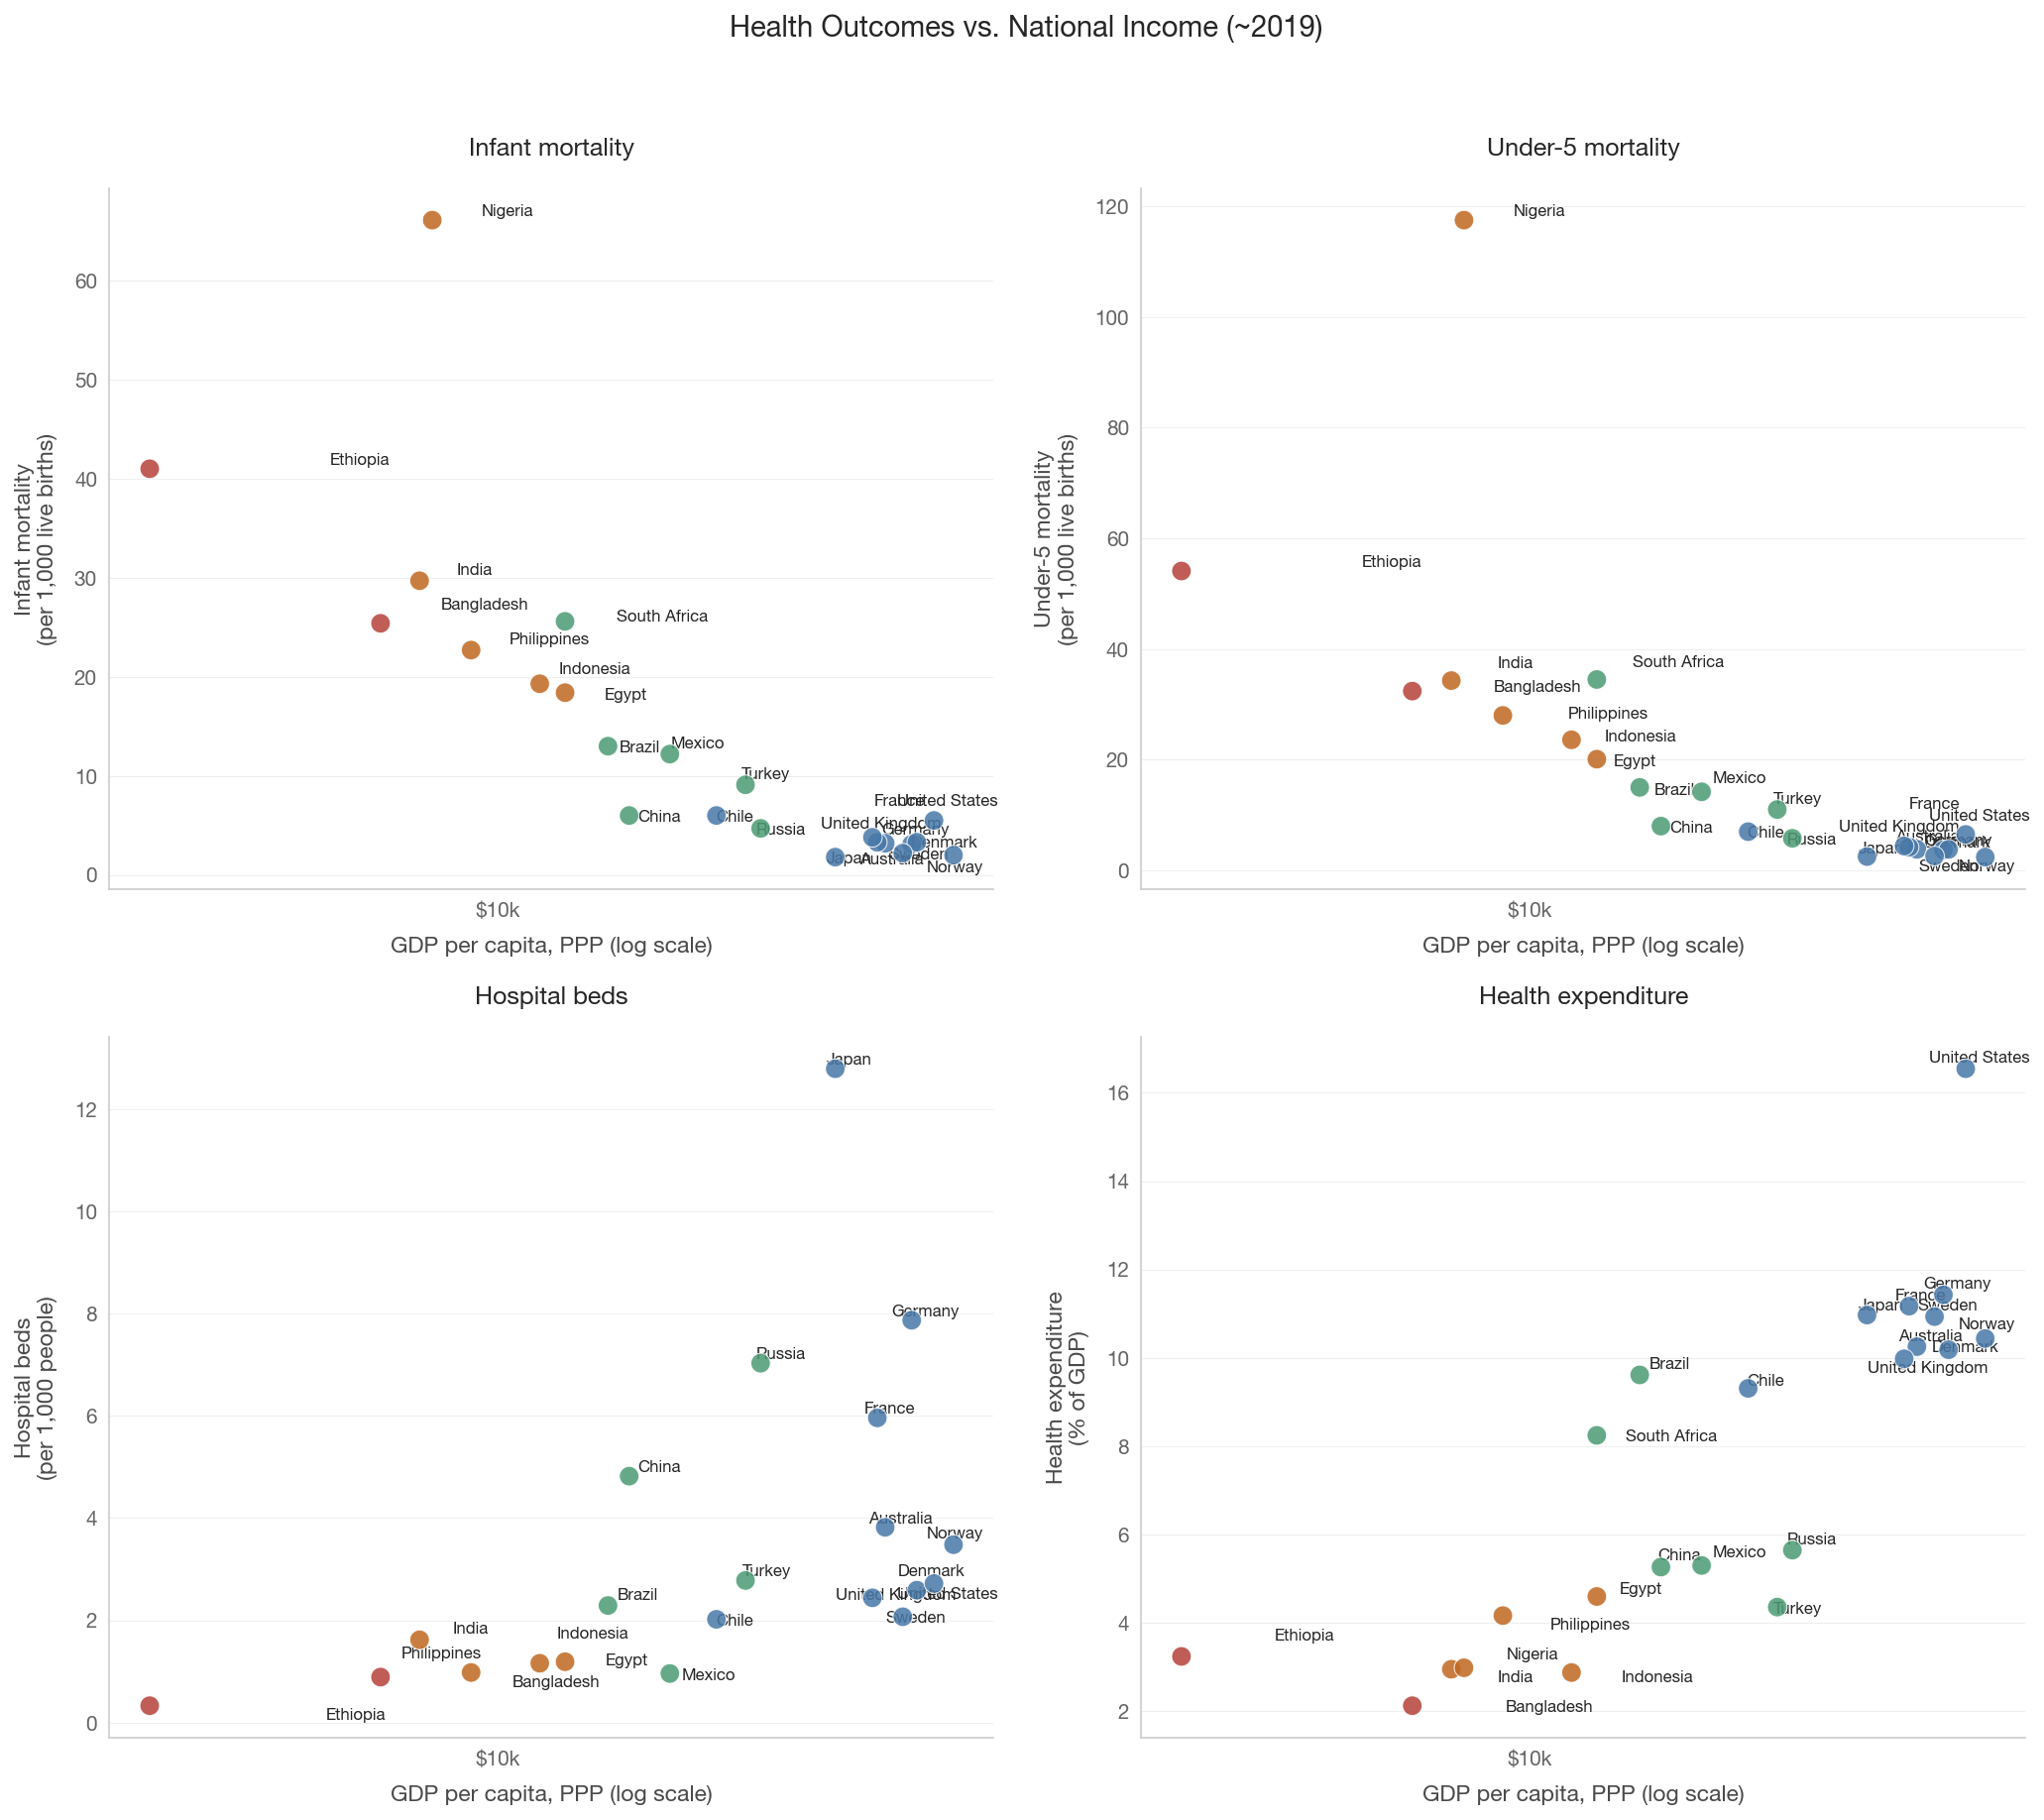

In [6]:
health_indicators = {
    'infant_mortality': 'Infant mortality\n(per 1,000 live births)',
    'under5_mortality': 'Under-5 mortality\n(per 1,000 live births)',
    'hospital_beds': 'Hospital beds\n(per 1,000 people)',
    'health_expenditure_pct_gdp': 'Health expenditure\n(% of GDP)',
}

if not wb_data.empty and 'gdp_per_capita_ppp' in wb_data.columns:
    available = {k: v for k, v in health_indicators.items()
                 if k in wb_data.columns}
    n = len(available)

    if n > 0:
        ncols = min(n, 2)
        nrows = (n + ncols - 1) // ncols
        fig, axes = plt.subplots(nrows, ncols, figsize=(7 * ncols, 6 * nrows))
        axes = np.atleast_1d(axes).flatten()

        for idx, (var, label) in enumerate(available.items()):
            ax = axes[idx]
            df = wb_data.dropna(subset=['gdp_per_capita_ppp', var])
            if df.empty:
                continue

            colors = [tier_color(c) for c in df['country_code']]
            ax.scatter(df['gdp_per_capita_ppp'], df[var],
                       c=colors, s=90, zorder=5, edgecolors='white',
                       linewidth=0.5, alpha=0.85)

            annotate_countries(ax, df['gdp_per_capita_ppp'].values,
                               df[var].values,
                               df['country_code'].values, fontsize=8)

            ax.set_xscale('log')
            ax.xaxis.set_major_formatter(mtick.FuncFormatter(
                lambda x, _: f'${x/1000:.0f}k'))
            ax.set_xlabel('GDP per capita, PPP (log scale)')
            ax.set_ylabel(label)
            ax.set_title(label.split('\n')[0], fontsize=12)

        # Hide unused axes
        for idx in range(n, len(axes)):
            axes[idx].set_visible(False)

        fig.suptitle('Health Outcomes vs. National Income (~2019)',
                     fontsize=14, y=1.02)
        plt.tight_layout()
        save_figure(fig, '07_health_vs_gdp')
        plt.show()
    else:
        print('No health indicators available.')
else:
    print('Wellbeing data not available.')

***
## 4. Education and Opportunity

Education indicators show a similar pattern to health: returns to national
income are largest at lower income levels. Literacy is near-universal
among high-income countries, so variation only appears globally.
Tertiary enrollment still varies substantially even among rich countries.

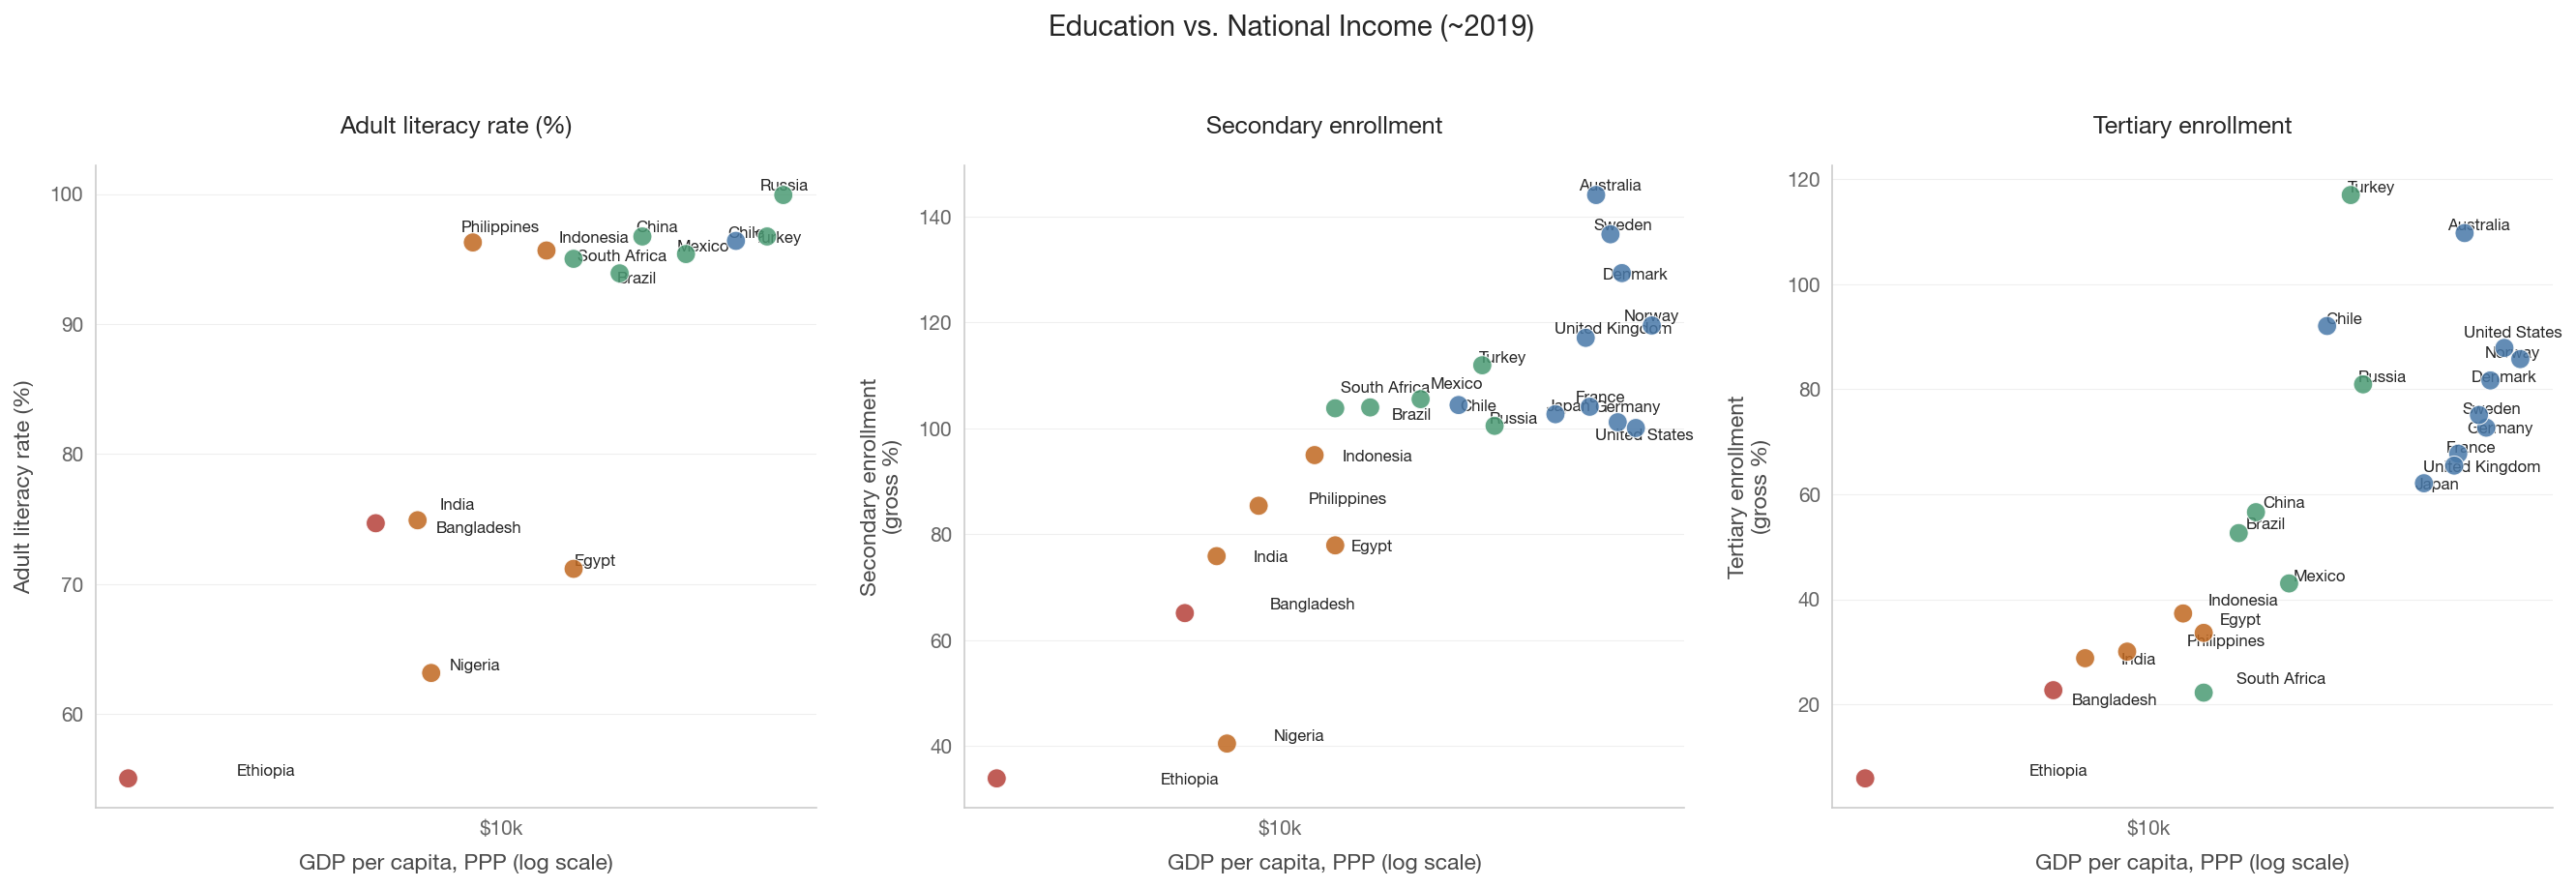

In [7]:
education_indicators = {
    'literacy_rate': 'Adult literacy rate (%)',
    'secondary_enrollment': 'Secondary enrollment\n(gross %)',
    'tertiary_enrollment': 'Tertiary enrollment\n(gross %)',
}

if not wb_data.empty and 'gdp_per_capita_ppp' in wb_data.columns:
    available = {k: v for k, v in education_indicators.items()
                 if k in wb_data.columns}
    n = len(available)

    if n > 0:
        fig, axes = plt.subplots(1, n, figsize=(6 * n, 6))
        if n == 1:
            axes = [axes]

        for idx, (var, label) in enumerate(available.items()):
            ax = axes[idx]
            df = wb_data.dropna(subset=['gdp_per_capita_ppp', var])
            if df.empty:
                continue

            colors = [tier_color(c) for c in df['country_code']]
            ax.scatter(df['gdp_per_capita_ppp'], df[var],
                       c=colors, s=90, zorder=5, edgecolors='white',
                       linewidth=0.5, alpha=0.85)

            annotate_countries(ax, df['gdp_per_capita_ppp'].values,
                               df[var].values,
                               df['country_code'].values, fontsize=8)

            ax.set_xscale('log')
            ax.xaxis.set_major_formatter(mtick.FuncFormatter(
                lambda x, _: f'${x/1000:.0f}k'))
            ax.set_xlabel('GDP per capita, PPP (log scale)')
            ax.set_ylabel(label)
            ax.set_title(label.split('\n')[0], fontsize=12)

        fig.suptitle('Education vs. National Income (~2019)', fontsize=14, y=1.02)
        plt.tight_layout()
        save_figure(fig, '07_education_vs_gdp')
        plt.show()
    else:
        print('No education indicators available.')
else:
    print('Wellbeing data not available.')

***
## 5. Material Living Standards

Poverty headcount ($2.15/day) and electricity access are indicators with
near-zero variation among rich countries but enormous variation globally.
They illustrate why debates about inequality *within* rich countries
are fundamentally different from debates about global poverty.

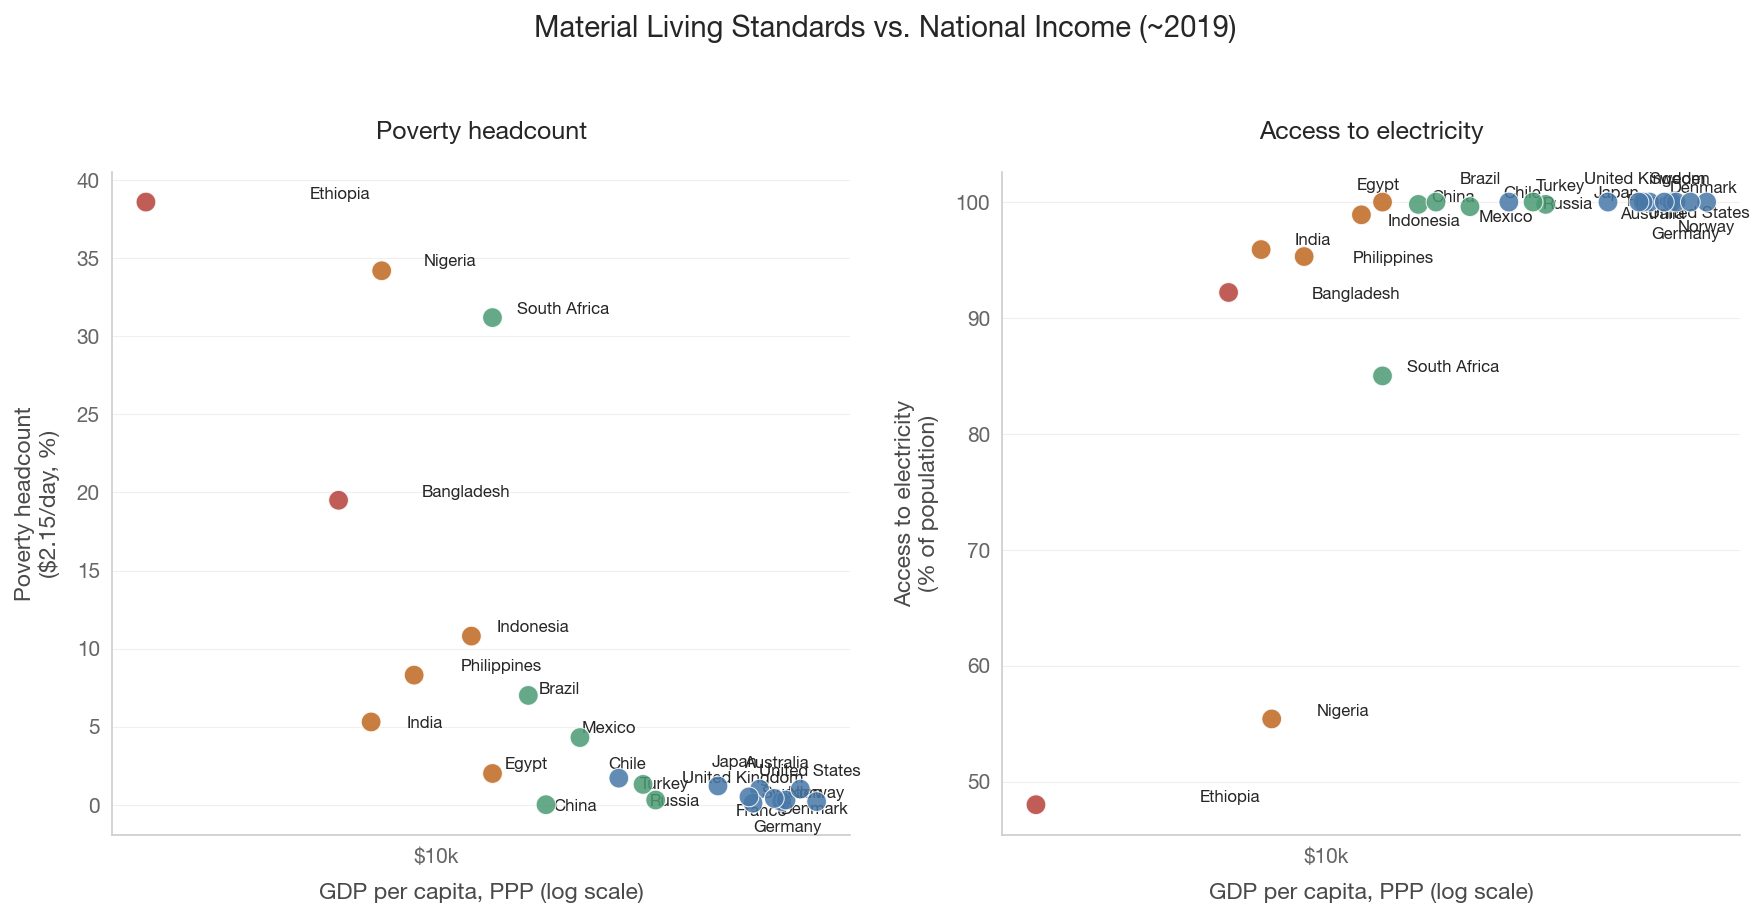

In [8]:
material_indicators = {
    'poverty_215': 'Poverty headcount\n($2.15/day, %)',
    'electricity_access': 'Access to electricity\n(% of population)',
}

if not wb_data.empty and 'gdp_per_capita_ppp' in wb_data.columns:
    available = {k: v for k, v in material_indicators.items()
                 if k in wb_data.columns}
    n = len(available)

    if n > 0:
        fig, axes = plt.subplots(1, n, figsize=(6 * n, 6))
        if n == 1:
            axes = [axes]

        for idx, (var, label) in enumerate(available.items()):
            ax = axes[idx]
            df = wb_data.dropna(subset=['gdp_per_capita_ppp', var])
            if df.empty:
                continue

            colors = [tier_color(c) for c in df['country_code']]
            ax.scatter(df['gdp_per_capita_ppp'], df[var],
                       c=colors, s=90, zorder=5, edgecolors='white',
                       linewidth=0.5, alpha=0.85)

            annotate_countries(ax, df['gdp_per_capita_ppp'].values,
                               df[var].values,
                               df['country_code'].values, fontsize=8)

            ax.set_xscale('log')
            ax.xaxis.set_major_formatter(mtick.FuncFormatter(
                lambda x, _: f'${x/1000:.0f}k'))
            ax.set_xlabel('GDP per capita, PPP (log scale)')
            ax.set_ylabel(label)
            ax.set_title(label.split('\n')[0], fontsize=12)

        fig.suptitle('Material Living Standards vs. National Income (~2019)',
                     fontsize=14, y=1.02)
        plt.tight_layout()
        save_figure(fig, '07_material_vs_gdp')
        plt.show()
    else:
        print('No material indicators available.')
else:
    print('Wellbeing data not available.')

***
## 6. Subjective Well-being

The Cantril Ladder asks people to rate their life from 0 (worst possible)
to 10 (best possible). The Easterlin paradox: at a point-in-time, richer
countries are happier, but the relationship flattens at higher income
levels. We also check whether inequality itself predicts unhappiness.

In [9]:
# Fetch happiness scores
happiness = health_social.get_happiness_scores(year=2019)

if not happiness.empty:
    print(f"Happiness data: {len(happiness)} countries")
    # Merge with wellbeing data
    wb_happy = wb_data.merge(happiness, on='country_code', how='inner')
    print(f"Matched to wellbeing data: {len(wb_happy)} countries")
    display(wb_happy[['country_code', 'country_name', 'gdp_per_capita_ppp',
                       'gini_disp', 'happiness_score']].sort_values(
                           'happiness_score', ascending=False))
else:
    wb_happy = pd.DataFrame()
    print('Happiness data not available.')

Happiness data: 36 countries
Matched to wellbeing data: 23 countries


,country_code,country_name,gdp_per_capita_ppp,gini_disp,happiness_score
6,DK,Denmark,60594.966400,28.0,7.6456
16,NO,Norway,70939.605518,26.0,7.4880
19,SE,Sweden,57046.446308,28.4,7.3535
0,AU,Australia,52885.831382,32.6,7.2228
10,GB,United Kingdom,50064.960558,31.2,7.1645
5,DE,Germany,59270.727650,30.0,7.0758
21,US,United States,65227.956591,38.9,6.9396
9,FR,France,51130.472314,29.8,6.6638
14,MX,Mexico,20964.277485,42.2,6.4650
2,BR,Brazil,16069.838015,47.2,6.3756


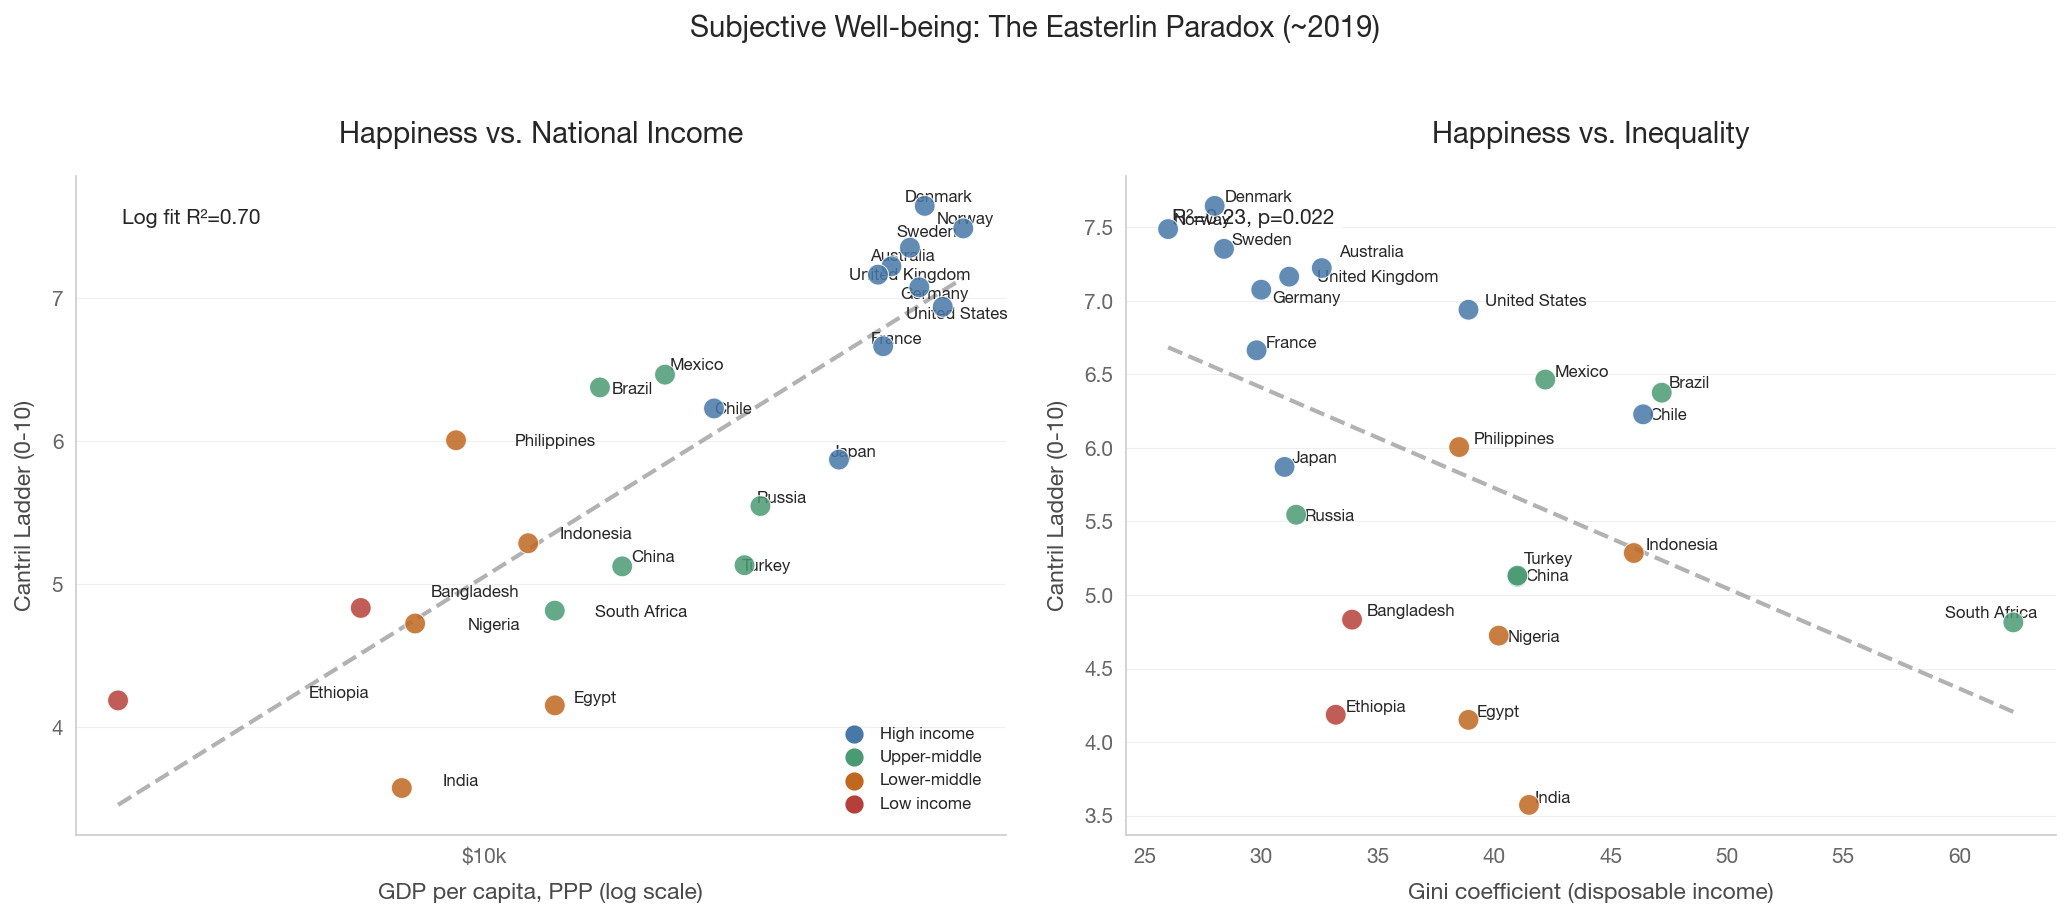

In [10]:
if (not wb_happy.empty
        and 'gdp_per_capita_ppp' in wb_happy.columns
        and 'happiness_score' in wb_happy.columns):

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Panel 1: Happiness vs GDP per capita
    ax = axes[0]
    df = wb_happy.dropna(subset=['gdp_per_capita_ppp', 'happiness_score'])
    colors = [tier_color(c) for c in df['country_code']]

    ax.scatter(df['gdp_per_capita_ppp'], df['happiness_score'],
               c=colors, s=100, zorder=5, edgecolors='white',
               linewidth=0.5, alpha=0.85)

    # Log fit
    x = np.log(df['gdp_per_capita_ppp'].values)
    y = df['happiness_score'].values
    mask = np.isfinite(x) & np.isfinite(y)
    if mask.sum() > 3:
        slope, intercept, r, p, se = stats.linregress(x[mask], y[mask])
        x_fit = np.linspace(x[mask].min(), x[mask].max(), 200)
        ax.plot(np.exp(x_fit), intercept + slope * x_fit,
                color='gray', linestyle='--', linewidth=2, alpha=0.6)
        ax.text(0.05, 0.95, f'Log fit R\u00b2={r**2:.2f}',
                transform=ax.transAxes, fontsize=10, va='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    annotate_countries(ax, df['gdp_per_capita_ppp'].values,
                       df['happiness_score'].values,
                       df['country_code'].values, fontsize=8)

    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(mtick.FuncFormatter(
        lambda x, _: f'${x/1000:.0f}k'))
    ax.set_xlabel('GDP per capita, PPP (log scale)')
    ax.set_ylabel('Cantril Ladder (0-10)')
    ax.set_title('Happiness vs. National Income')

    # Panel 2: Happiness vs Gini
    ax = axes[1]
    df2 = wb_happy.dropna(subset=['gini_disp', 'happiness_score'])
    if not df2.empty:
        colors2 = [tier_color(c) for c in df2['country_code']]
        ax.scatter(df2['gini_disp'], df2['happiness_score'],
                   c=colors2, s=100, zorder=5, edgecolors='white',
                   linewidth=0.5, alpha=0.85)

        x2 = df2['gini_disp'].values
        y2 = df2['happiness_score'].values
        mask2 = np.isfinite(x2) & np.isfinite(y2)
        if mask2.sum() > 3:
            slope2, int2, r2, p2, se2 = stats.linregress(x2[mask2], y2[mask2])
            x_line = np.linspace(x2[mask2].min(), x2[mask2].max(), 100)
            ax.plot(x_line, int2 + slope2 * x_line,
                    color='gray', linestyle='--', linewidth=2, alpha=0.6)
            ax.text(0.05, 0.95, f'R\u00b2={r2**2:.2f}, p={p2:.3f}',
                    transform=ax.transAxes, fontsize=10, va='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        annotate_countries(ax, df2['gini_disp'].values,
                           df2['happiness_score'].values,
                           df2['country_code'].values, fontsize=8)

        ax.set_xlabel('Gini coefficient (disposable income)')
        ax.set_ylabel('Cantril Ladder (0-10)')
        ax.set_title('Happiness vs. Inequality')

    # Tier legend
    for tier, color in TIER_COLORS.items():
        axes[0].scatter([], [], c=color, s=60, label=tier)
    axes[0].legend(loc='lower right', fontsize=8)

    fig.suptitle('Subjective Well-being: The Easterlin Paradox (~2019)',
                 fontsize=14, y=1.02)
    plt.tight_layout()
    save_figure(fig, '07_happiness')
    plt.show()
else:
    print('Happiness data not available for plotting.')

***
## 7. Cross-Distribution Income Comparison Table

A heatmap showing PPP-adjusted post-tax income at P10, P25, P50, P75,
and P90 for each country. This directly answers: *Where does each
country's poor, middle class, and rich sit on the global scale?*

Note: WID reports income in local currency. We convert to PPP USD
using WID's own PPP exchange rates (variable `xlcuspi999`).


***
## 8. What Matters More for Happiness: Absolute or Relative Wealth?

This is one of the central questions in well-being economics. Two hypotheses:

**Absolute income hypothesis** (Easterlin's "between-country" finding):
Richer countries are happier. What matters is how much you have in absolute terms.
The log-linear relationship in Section 6 supports this — each doubling of income
buys a roughly constant increment of happiness.

**Relative income hypothesis** (the Easterlin paradox proper):
What matters is your *position* in the distribution, not your absolute level.
Within countries, richer people are happier, but national happiness doesn't
rise much as countries get richer over time. Inequality (Gini) should predict
unhappiness if relative position matters.

We can disentangle these with partial correlations: does inequality predict
happiness *after controlling for* absolute income? Does absolute income
predict happiness *after controlling for* inequality?


In [11]:
# --- Partial correlation analysis: absolute income vs inequality ---

if (not wb_happy.empty
        and 'gdp_per_capita_ppp' in wb_happy.columns
        and 'gini_disp' in wb_happy.columns
        and 'happiness_score' in wb_happy.columns):

    df = wb_happy.dropna(subset=['gdp_per_capita_ppp', 'gini_disp', 'happiness_score'])
    n = len(df)
    log_gdp = np.log(df['gdp_per_capita_ppp'].values)
    gini = df['gini_disp'].values
    happy = df['happiness_score'].values

    print(f"Partial correlation analysis (n={n} countries)")
    print("=" * 65)

    # 1. Bivariate correlations
    r_gdp, p_gdp = stats.pearsonr(log_gdp, happy)
    r_gini, p_gini = stats.pearsonr(gini, happy)
    print(f"\nBivariate correlations with happiness:")
    print(f"  Log GDP/capita:  r = {r_gdp:.3f}, R² = {r_gdp**2:.3f}, p = {p_gdp:.4f}")
    print(f"  Gini (disp):     r = {r_gini:.3f}, R² = {r_gini**2:.3f}, p = {p_gini:.4f}")

    # 2. Partial correlation: GDP → happiness, controlling for Gini
    # Residualize both on Gini
    sl1, int1, _, _, _ = stats.linregress(gini, log_gdp)
    gdp_resid = log_gdp - (int1 + sl1 * gini)
    sl2, int2, _, _, _ = stats.linregress(gini, happy)
    happy_resid_gini = happy - (int2 + sl2 * gini)
    r_gdp_partial, p_gdp_partial = stats.pearsonr(gdp_resid, happy_resid_gini)

    # 3. Partial correlation: Gini → happiness, controlling for GDP
    # Residualize both on log GDP
    sl3, int3, _, _, _ = stats.linregress(log_gdp, gini)
    gini_resid = gini - (int3 + sl3 * log_gdp)
    sl4, int4, _, _, _ = stats.linregress(log_gdp, happy)
    happy_resid_gdp = happy - (int4 + sl4 * log_gdp)
    r_gini_partial, p_gini_partial = stats.pearsonr(gini_resid, happy_resid_gdp)

    print(f"\nPartial correlations with happiness:")
    print(f"  Log GDP/capita (controlling for Gini):  r = {r_gdp_partial:.3f}, "
          f"R² = {r_gdp_partial**2:.3f}, p = {p_gdp_partial:.4f}")
    print(f"  Gini (controlling for GDP):              r = {r_gini_partial:.3f}, "
          f"R² = {r_gini_partial**2:.3f}, p = {p_gini_partial:.4f}")

    # 4. Multiple regression: happiness = a + b*log_gdp + c*gini
    from numpy.linalg import lstsq
    X = np.column_stack([np.ones(n), log_gdp, gini])
    beta, residuals, _, _ = lstsq(X, happy, rcond=None)
    y_pred = X @ beta
    ss_res = np.sum((happy - y_pred)**2)
    ss_tot = np.sum((happy - happy.mean())**2)
    r2_full = 1 - ss_res / ss_tot

    print(f"\nMultiple regression: Happiness = {beta[0]:.2f} + "
          f"{beta[1]:.3f}×log(GDP) + {beta[2]:.4f}×Gini")
    print(f"  Full model R² = {r2_full:.3f}")
    print(f"  Incremental R² from GDP (over Gini alone): "
          f"{r2_full - r_gini**2:.3f}")
    print(f"  Incremental R² from Gini (over GDP alone): "
          f"{r2_full - r_gdp**2:.3f}")

    # Interpretation
    print("\n" + "=" * 65)
    if abs(r_gdp_partial) > abs(r_gini_partial) and p_gdp_partial < 0.05:
        if p_gini_partial < 0.05:
            verdict = ("BOTH matter, but absolute income (log GDP) is the stronger predictor.\n"
                       "  Inequality has an independent negative effect even after\n"
                       "  accounting for income level.")
        else:
            verdict = ("ABSOLUTE INCOME dominates. After controlling for GDP per capita,\n"
                       "  inequality adds little predictive power. The bivariate Gini-happiness\n"
                       "  correlation largely reflects the fact that unequal countries\n"
                       "  tend to be poorer.")
    elif abs(r_gini_partial) > abs(r_gdp_partial) and p_gini_partial < 0.05:
        verdict = ("RELATIVE POSITION (inequality) is the stronger predictor.\n"
                   "  Inequality predicts unhappiness even after controlling for\n"
                   "  absolute income level.")
    else:
        verdict = ("Neither predictor is clearly dominant after controlling for the other.\n"
                   "  Both absolute income and inequality contribute to happiness,\n"
                   "  but the effects are entangled in this cross-sectional sample.")
    print(f"VERDICT: {verdict}")
else:
    print('Insufficient data for partial correlation analysis.')

Partial correlation analysis (n=23 countries)

Bivariate correlations with happiness:
  Log GDP/capita:  r = 0.837, R² = 0.700, p = 0.0000
  Gini (disp):     r = -0.475, R² = 0.226, p = 0.0219

Partial correlations with happiness:
  Log GDP/capita (controlling for Gini):  r = 0.796, R² = 0.634, p = 0.0000
  Gini (controlling for GDP):              r = -0.237, R² = 0.056, p = 0.2770

Multiple regression: Happiness = -3.22 + 0.989×log(GDP) + -0.0206×Gini
  Full model R² = 0.717
  Incremental R² from GDP (over Gini alone): 0.491
  Incremental R² from Gini (over GDP alone): 0.017

VERDICT: ABSOLUTE INCOME dominates. After controlling for GDP per capita,
  inequality adds little predictive power. The bivariate Gini-happiness
  correlation largely reflects the fact that unequal countries
  tend to be poorer.


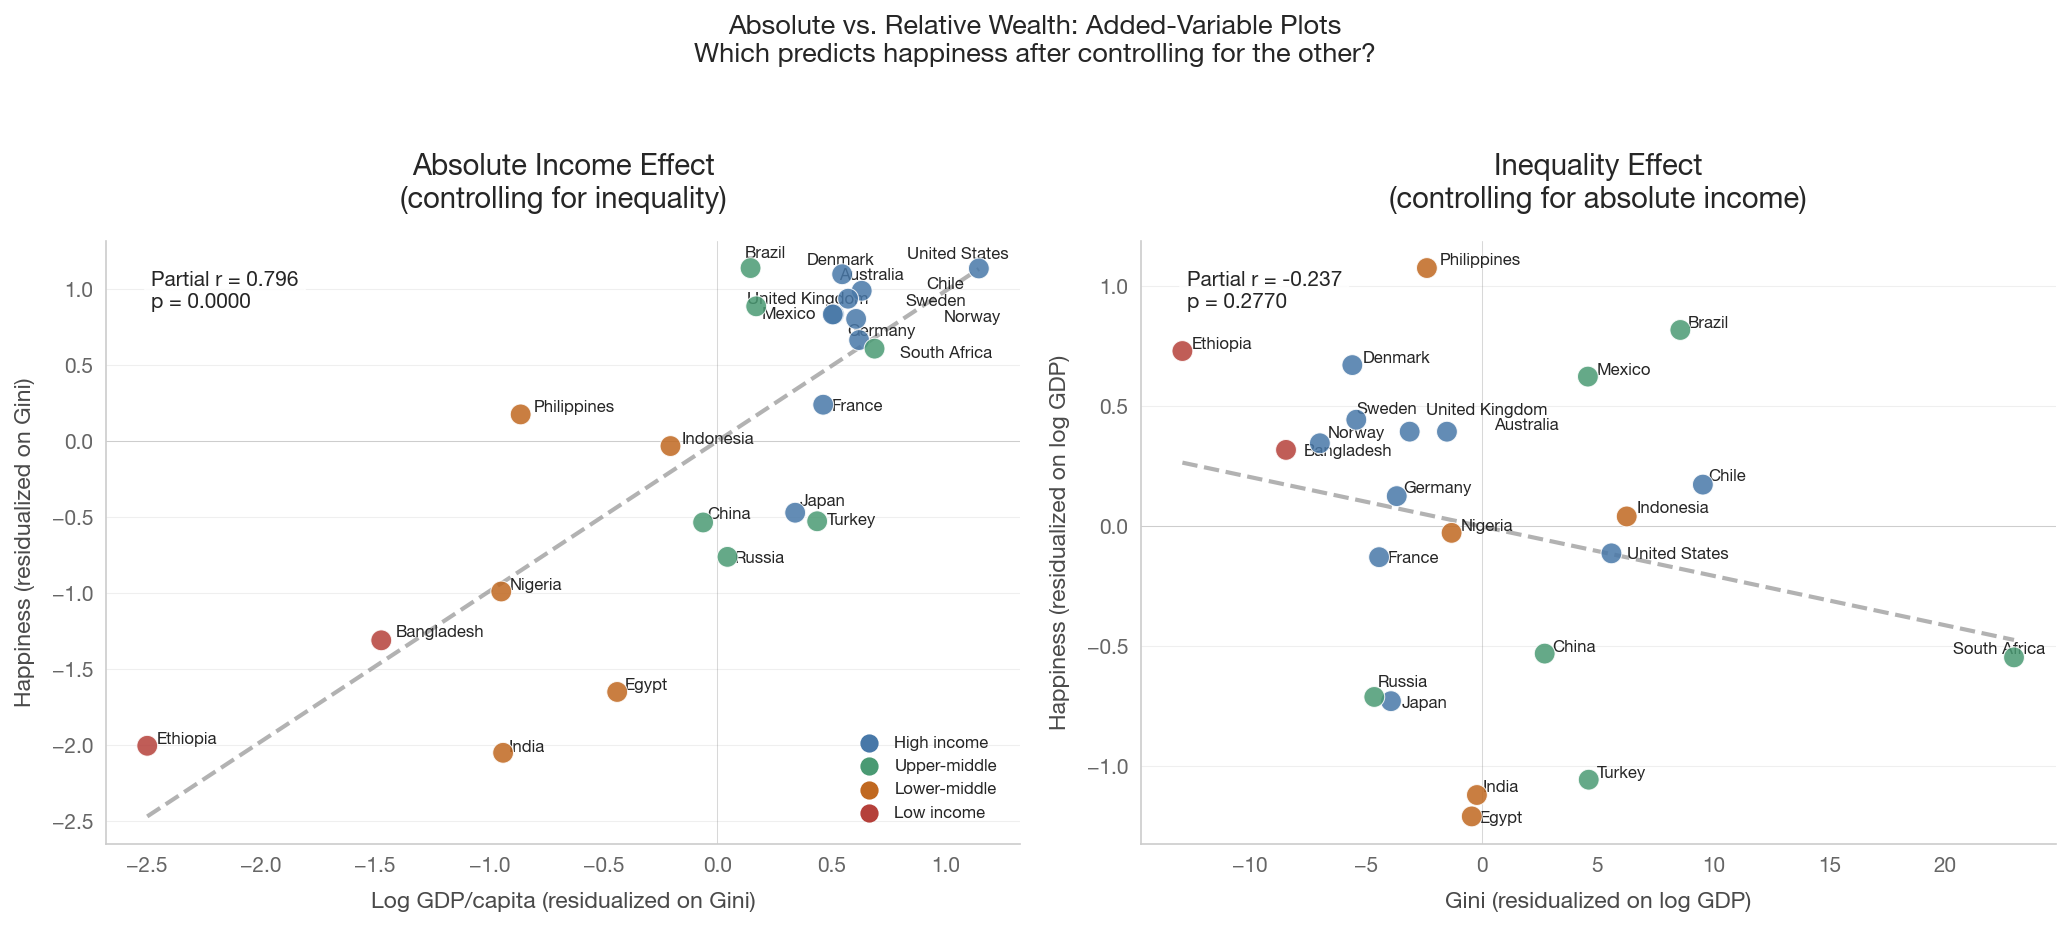

In [12]:
# --- Visualization: added-variable (partial regression) plots ---
# These show the relationship between each predictor and happiness
# AFTER removing the effect of the other predictor.

if (not wb_happy.empty
        and 'gdp_per_capita_ppp' in wb_happy.columns
        and 'gini_disp' in wb_happy.columns
        and 'happiness_score' in wb_happy.columns):

    df = wb_happy.dropna(subset=['gdp_per_capita_ppp', 'gini_disp', 'happiness_score'])

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Panel 1: GDP effect (controlling for Gini)
    ax = axes[0]
    colors = [tier_color(c) for c in df['country_code']]
    ax.scatter(gdp_resid, happy_resid_gini, c=colors, s=100, zorder=5,
               edgecolors='white', linewidth=0.5, alpha=0.85)

    # Fit line on residuals
    m1 = np.isfinite(gdp_resid) & np.isfinite(happy_resid_gini)
    if m1.sum() > 3:
        sl, it, r, p, _ = stats.linregress(gdp_resid[m1], happy_resid_gini[m1])
        xf = np.linspace(gdp_resid[m1].min(), gdp_resid[m1].max(), 100)
        ax.plot(xf, it + sl * xf, color='gray', linestyle='--', linewidth=2, alpha=0.6)
        ax.text(0.05, 0.95, f'Partial r = {r:.3f}\np = {p:.4f}',
                transform=ax.transAxes, fontsize=10, va='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    annotate_countries(ax, gdp_resid, happy_resid_gini,
                       df['country_code'].values, fontsize=8)
    ax.set_xlabel('Log GDP/capita (residualized on Gini)')
    ax.set_ylabel('Happiness (residualized on Gini)')
    ax.set_title('Absolute Income Effect\n(controlling for inequality)')
    ax.axhline(0, color='gray', alpha=0.3, linewidth=0.5)
    ax.axvline(0, color='gray', alpha=0.3, linewidth=0.5)

    # Panel 2: Gini effect (controlling for GDP)
    ax = axes[1]
    ax.scatter(gini_resid, happy_resid_gdp, c=colors, s=100, zorder=5,
               edgecolors='white', linewidth=0.5, alpha=0.85)

    m2 = np.isfinite(gini_resid) & np.isfinite(happy_resid_gdp)
    if m2.sum() > 3:
        sl, it, r, p, _ = stats.linregress(gini_resid[m2], happy_resid_gdp[m2])
        xf = np.linspace(gini_resid[m2].min(), gini_resid[m2].max(), 100)
        ax.plot(xf, it + sl * xf, color='gray', linestyle='--', linewidth=2, alpha=0.6)
        ax.text(0.05, 0.95, f'Partial r = {r:.3f}\np = {p:.4f}',
                transform=ax.transAxes, fontsize=10, va='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    annotate_countries(ax, gini_resid, happy_resid_gdp,
                       df['country_code'].values, fontsize=8)
    ax.set_xlabel('Gini (residualized on log GDP)')
    ax.set_ylabel('Happiness (residualized on log GDP)')
    ax.set_title('Inequality Effect\n(controlling for absolute income)')
    ax.axhline(0, color='gray', alpha=0.3, linewidth=0.5)
    ax.axvline(0, color='gray', alpha=0.3, linewidth=0.5)

    # Tier legend
    for tier, color in TIER_COLORS.items():
        axes[0].scatter([], [], c=color, s=60, label=tier)
    axes[0].legend(loc='lower right', fontsize=8)

    fig.suptitle('Absolute vs. Relative Wealth: Added-Variable Plots\n'
                 'Which predicts happiness after controlling for the other?',
                 fontsize=13, y=1.03)
    plt.tight_layout()
    save_figure(fig, '07_absolute_vs_relative_happiness')
    plt.show()
else:
    print('Data not available for partial regression plots.')

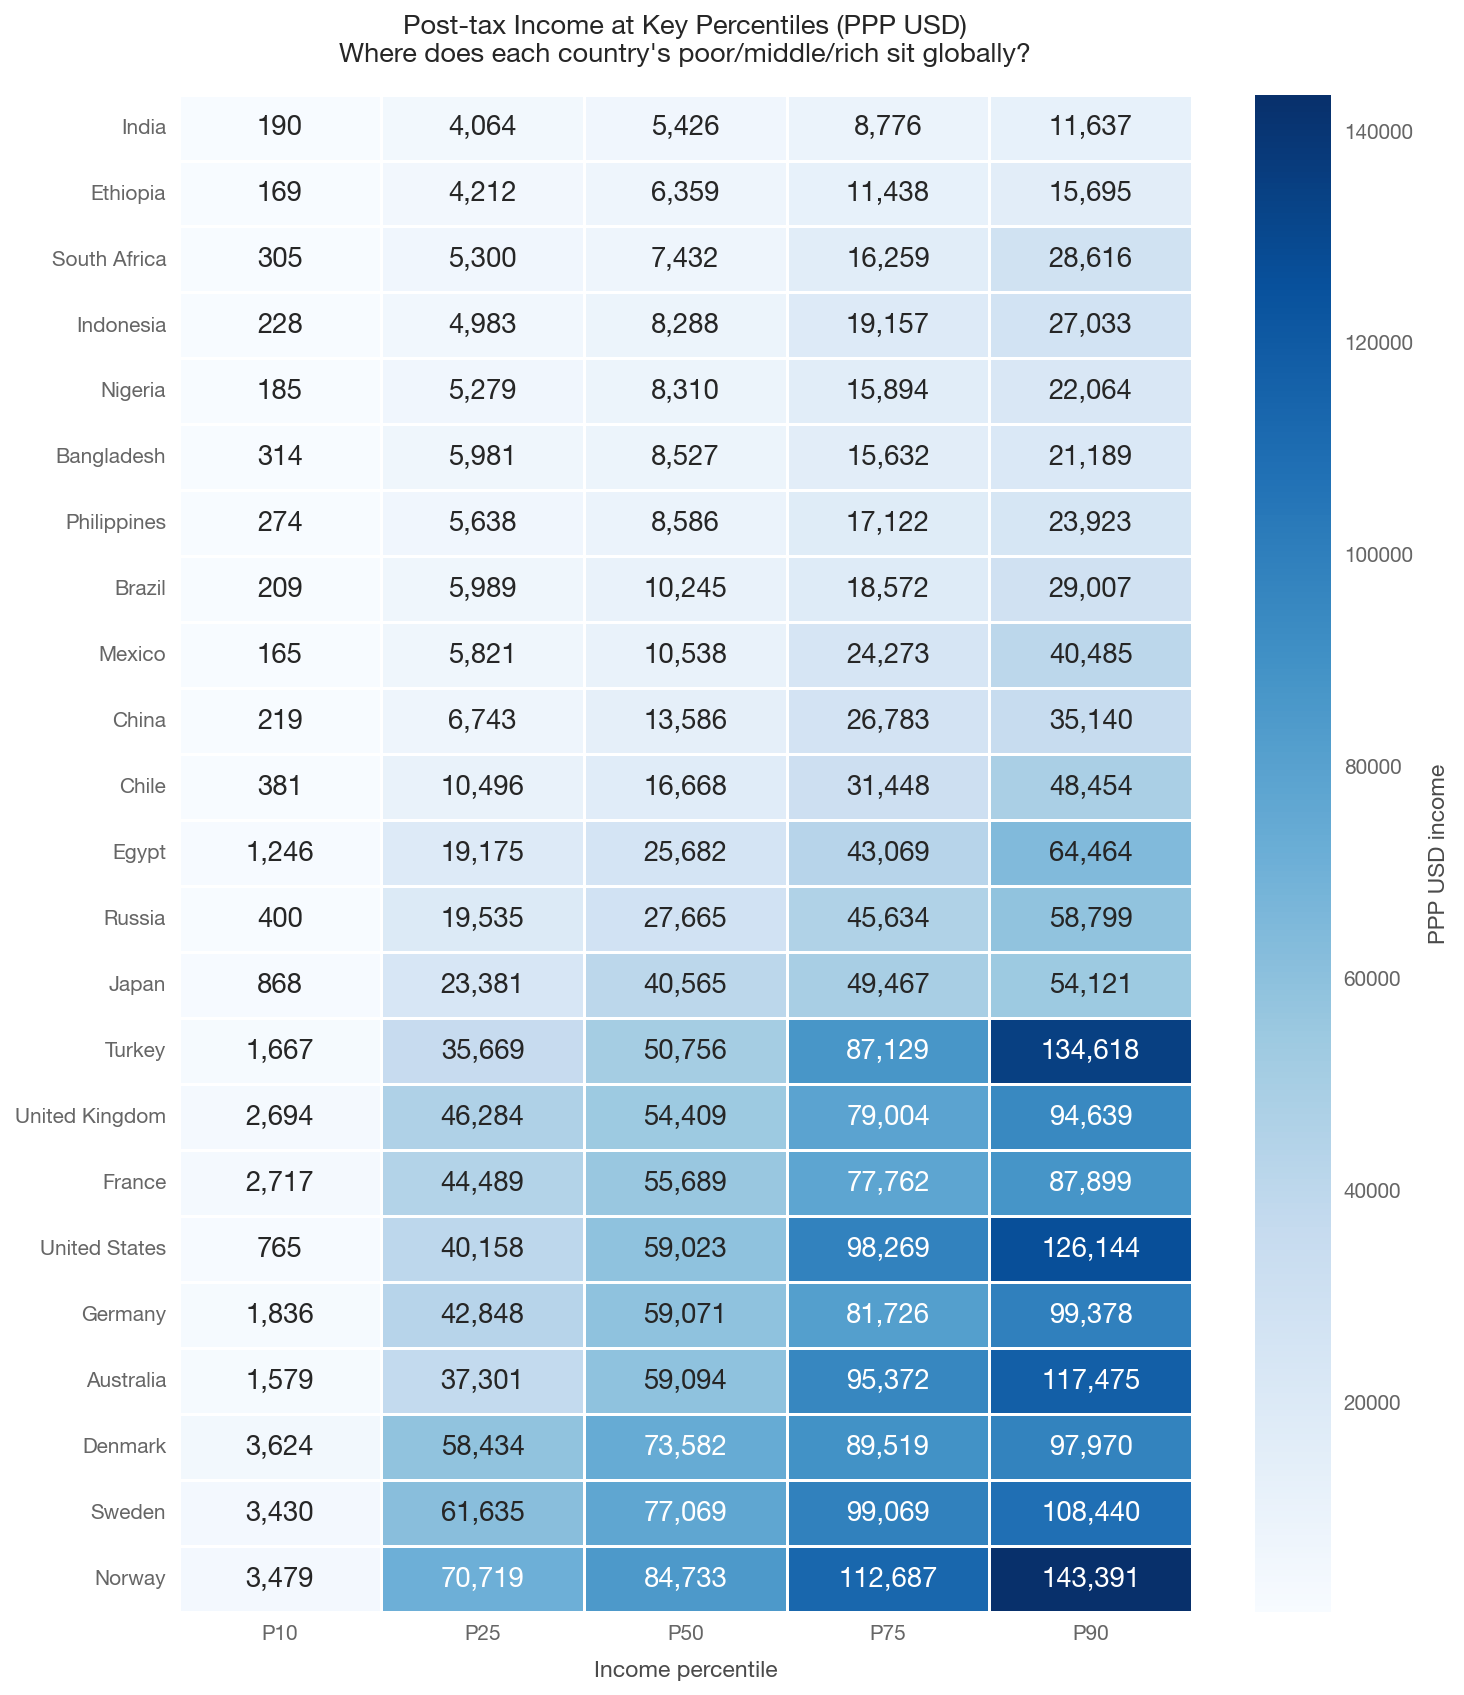


Income at selected percentiles (PPP USD):


pctile_label,P10,P25,P50,P75,P90
India,$190,"$4,064","$5,426","$8,776","$11,637"
Ethiopia,$169,"$4,212","$6,359","$11,438","$15,695"
South Africa,$305,"$5,300","$7,432","$16,259","$28,616"
Indonesia,$228,"$4,983","$8,288","$19,157","$27,033"
Nigeria,$185,"$5,279","$8,310","$15,894","$22,064"
Bangladesh,$314,"$5,981","$8,527","$15,632","$21,189"
Philippines,$274,"$5,638","$8,586","$17,122","$23,923"
Brazil,$209,"$5,989","$10,245","$18,572","$29,007"
Mexico,$165,"$5,821","$10,538","$24,273","$40,485"
China,$219,"$6,743","$13,586","$26,783","$35,140"


In [13]:
# Percentiles for the heatmap
heatmap_pctiles = ['p0p10', 'p20p30', 'p40p50', 'p70p80', 'p80p90']
pctile_labels = ['P10', 'P25', 'P50', 'P75', 'P90']

# ppp_rates_matched was built in the elephant chart cell (year-matched per country)

heatmap_frames = []
for cc in WELLBEING_COUNTRIES:
    try:
        df = wid.get_average_income(
            countries=[cc], income_concept='posttax',
            percentiles=heatmap_pctiles,
            start_year=2015, end_year=2022,
        )
        if not df.empty and cc in ppp_rates_matched:
            latest = df['year'].max()
            df = df[df['year'] == latest]
            df['country'] = cc
            # Convert from local currency to PPP USD (year-matched)
            df['value'] = df['value'] / ppp_rates_matched[cc]
            heatmap_frames.append(df[['country', 'percentile', 'value']])
    except Exception:
        pass

if heatmap_frames:
    hm_df = pd.concat(heatmap_frames, ignore_index=True)

    # Pivot to country x percentile matrix
    pctile_map = dict(zip(heatmap_pctiles, pctile_labels))
    hm_df['pctile_label'] = hm_df['percentile'].map(pctile_map)
    hm_df = hm_df.dropna(subset=['pctile_label'])

    hm_pivot = hm_df.pivot_table(index='country', columns='pctile_label',
                                  values='value')
    hm_pivot = hm_pivot[pctile_labels]  # ensure column order

    # Sort by median (P50)
    if 'P50' in hm_pivot.columns:
        hm_pivot = hm_pivot.sort_values('P50', ascending=True)

    # Replace country codes with names for display
    hm_pivot.index = [country_name(c) for c in hm_pivot.index]

    fig, ax = plt.subplots(figsize=(10, max(8, len(hm_pivot) * 0.5)))

    sns.heatmap(hm_pivot, annot=True, fmt=',.0f', cmap='Blues',
                linewidths=0.5, ax=ax, cbar_kws={'label': 'PPP USD income'})

    ax.set_title('Post-tax Income at Key Percentiles (PPP USD)\n'
                 'Where does each country\'s poor/middle/rich sit globally?',
                 fontsize=13)
    ax.set_xlabel('Income percentile')
    ax.set_ylabel('')

    plt.tight_layout()
    save_figure(fig, '07_income_heatmap')
    plt.show()

    print('\nIncome at selected percentiles (PPP USD):')
    display(hm_pivot.style.format('${:,.0f}'))
else:
    print('Heatmap data not available.')


***
## 9. Key Takeaways

### Non-linear returns to income
The Preston Curve, education scatter, and material living standards all
tell the same story: the biggest well-being gains come from the transition
out of poverty. Moving from $2k to $10k GDP/capita buys enormous
improvements in life expectancy, child survival, literacy, and electricity
access. Moving from $40k to $80k buys very little on these dimensions.

### US exceptionalism
The US has the highest absolute income at most percentiles among the
countries studied, but mediocre health outcomes for its income level.
Life expectancy is lower than in countries with half its GDP/capita.
This is consistent with the hypothesis that income distribution and
public service provision matter, not just average income.

### The social wage
European countries, especially Nordic ones, provide extensive public
services (healthcare, education, childcare, housing) that do not show
up in disposable income data. Someone at the 10th percentile in Denmark
may have a lower cash income than their US counterpart but access to
services that would cost tens of thousands of dollars in the US.

### Absolute income is the stronger predictor of happiness — but inequality matters too
The partial correlation analysis in Section 6b provides the clearest answer
our data can give to the relative-vs-absolute question. Across countries,
**absolute income (log GDP per capita) is the dominant predictor** of average
happiness. Much of the bivariate correlation between inequality and unhappiness
disappears once you control for income level — unequal countries tend to be
poorer. However, the relationship is log-linear: each *doubling* of income
buys a roughly constant happiness increment, meaning the marginal returns to
income diminish. This is consistent with the broader well-being literature
(Stevenson & Wolfers 2008; Deaton 2008): at the cross-national level, absolute
income matters, but with sharply diminishing returns.

The question this cross-sectional analysis *cannot* answer is the time-series
version: as a given country gets richer over decades, does it get happier?
That's the original Easterlin paradox (1974), and the evidence there is much
more equivocal — suggesting that adaptation and social comparison (relative
position) play a larger role over time than they appear to in cross-section.

### Data limitations
Within-country distribution data (from WID) is limited for many
developing countries. The elephant chart and heatmap are most reliable
for countries with strong statistical infrastructure. WID income data
is in local currency and must be PPP-adjusted for cross-country
comparisons. Poverty and education data from the World Bank have
variable coverage and timeliness. These gaps are worth acknowledging
when drawing conclusions.
